**DATA EXPLORATION**




In [0]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np

In [168]:
names = ['timestamp','par1','par2','par3','par4']
data = pd.read_csv('/content/machine_0.csv',names= names)
df = data[1:]
df.head()

,timestamp,par1,par2,par3,par4
1,2019-01-01 00:00:00.000000000,12.626096,8.803120,-11.809200,10.083961
2,2019-01-01 08:00:09.603201067,10.831994,2.816327,11.554778,21.892853
3,2019-01-01 16:00:19.206402134,21.083510,-0.672645,-17.839178,-1.349024
4,2019-01-02 00:00:28.809603201,32.294495,6.525132,-13.498586,-4.250752
5,2019-01-02 08:00:38.412804268,28.057100,3.691359,21.984744,13.670561


In [169]:

df['timestamp']=pd.to_datetime(df['timestamp'])
df.head()


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,timestamp,par1,par2,par3,par4
1,2019-01-01 00:00:00.000000000,12.626096,8.803120,-11.809200,10.083961
2,2019-01-01 08:00:09.603201067,10.831994,2.816327,11.554778,21.892853
3,2019-01-01 16:00:19.206402134,21.083510,-0.672645,-17.839178,-1.349024
4,2019-01-02 00:00:28.809603201,32.294495,6.525132,-13.498586,-4.250752
5,2019-01-02 08:00:38.412804268,28.057100,3.691359,21.984744,13.670561


In [170]:
df.describe()

,par1,par2,par3,par4
count,3000.000000,3000.000000,3000.000000,3000.000000
mean,-0.816016,-1.091308,1.267945,0.165844
std,58.078319,55.965665,56.538700,56.910659
min,-323.954437,-258.780879,-287.153920,-365.362164
25%,-0.008684,-0.008851,-0.008274,-0.007883
50%,-0.000402,-0.000085,0.000669,0.000310
75%,0.007832,0.008373,0.009056,0.008685
max,315.738951,264.374782,281.684102,340.513819


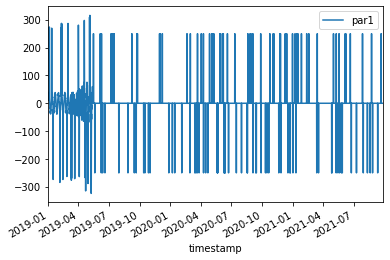

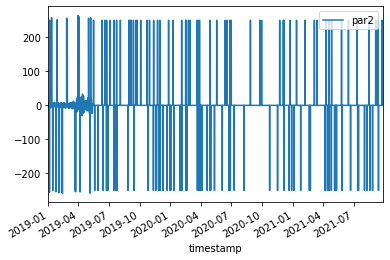

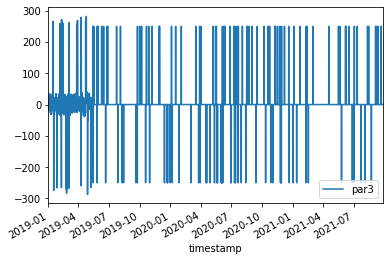

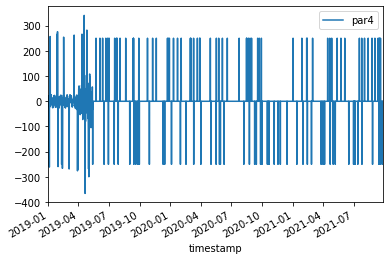

In [171]:
#plot some of the columns to get an idea of the trends over time
df.plot(x="timestamp", y="par1", kind="line")
df.plot(x="timestamp", y="par2", kind="line")
df.plot(x="timestamp", y="par3", kind="line")
df.plot(x="timestamp", y="par4", kind="line")

In [163]:
df['Total']= df.select_dtypes(include=['float64','float32']).apply(lambda row: np.sum(row),axis=1)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [164]:
df.head()

,timestamp,par1,par2,par3,par4,Total
1,2019-01-01 00:00:00.000000000,12.588243,8.829718,-11.803474,10.083107,19.697594
2,2019-01-01 08:00:09.603201067,10.822199,2.795246,11.560279,21.898688,47.076412
3,2019-01-01 16:00:19.206402134,21.074661,-0.655051,-17.840580,-1.346748,1.232282
4,2019-01-02 00:00:28.809603201,32.284431,6.544655,-13.498907,-4.281704,21.048474
5,2019-01-02 08:00:38.412804268,28.073949,253.681988,271.983917,263.627071,817.366924


**In order to recognize the noise signals I am adding up all 4 signal outputs and plotting them as time series data**

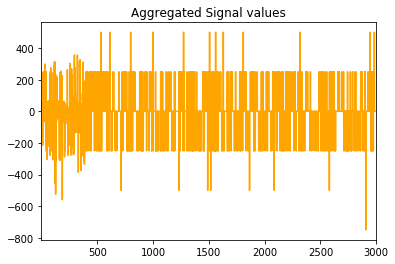

In [92]:

timeseries = pd.Series(df['Total'])
timeseries.plot(c = 'orange', title = 'Aggregated Signal values')

**The spikes in the plot above indicates the noise and hence indication of the failure of the machine**

**DATA PREPARATION AND MODEL BULDING**

In [0]:
# Preparing data 
Future_period = 65
f_horizon = 1          # Number of periods we are forecasting
ts_array = np.array(timeseries)
#print(ts_array[:5])
#print(len(ts_array))

In [104]:
# Preparing training X data 
X_train = ts_array[:(len(ts_array)-(len(ts_array) % Future_period))]
#print(len(X_train))
#print(X_train[:10])
x_batches = X_train.reshape(-1, Future_period, 1)
print (len(x_batches))
print (x_batches.shape)
#print (x_batches[0:3])

46
(46, 65, 1)


In [106]:
# Creating training output dataset
y_train =  ts_array[1:(len(ts_array)-(len(ts_array) % Future_period))+f_horizon]
#print(y_train[:5])
#print(len(y_train))
#print(y_train.shape)
y_baches = y_train.reshape(-1, Future_period, 1)
#print(len(y_baches))



[47.09595164  1.2226637  21.0702889  67.40376361 26.47334236]
2990
(2990,)
46


In [0]:
#create our test X and y data
def test_data(series,forecast,Future_period):
    test_x_setup = series[-(Future_period + forecast):]
    testX = test_x_setup[:Future_period].reshape(-1, Future_period, 1)
    testY = ts_array[-(Future_period):].reshape(-1, Future_period, 1)
    return testX,testY

In [0]:
X_test, Y_test = test_data(ts_array,f_horizon,Future_period)
#print (X_test.shape)
#print (X_test[:,(Future_period-1):Future_period])
#print (Y_test.shape)
#print (Y_test[:,(Future_period-1):Future_period])


In [0]:
import tensorflow as tf
import shutil
import tensorflow.contrib.learn as tflearn
import tensorflow.contrib.layers as tflayers
from tensorflow.contrib.learn.python.learn import learn_runner
import tensorflow.contrib.metrics as metrics
import tensorflow.contrib.rnn as rnn

In [0]:
tf.reset_default_graph()

inputt = 1
hidden = 200
output = 1


X = tf.placeholder(tf.float32, [None, Future_period, inputt], name = "X")   #create variable objects
y = tf.placeholder(tf.float32, [None, Future_period, output], name = "y")   #create variable objects


In [0]:
basic_cell = tf.contrib.rnn.BasicRNNCell(num_units=hidden, activation=tf.nn.relu)
rnn_output, states = tf.nn.dynamic_rnn(basic_cell, X, dtype=tf.float32) 

In [0]:
LR = 0.001
stacked_rnn_output = tf.reshape(rnn_output, [-1, hidden])           #change the form into a tensor
stacked_outputs = tf.layers.dense(stacked_rnn_output, output)        #specify the type of layer (dense)
outputs = tf.reshape(stacked_outputs, [-1, Future_period, output])          #shape of results
 

In [0]:
loss = tf.reduce_sum(tf.square(outputs - y),name='loss')                 #define the cost function which evaluates the quality of our model
optimizer = tf.train.AdamOptimizer(learning_rate=LR)          #gradient descent method
training_op = optimizer.minimize(loss)                                   #train the result of the application of the cost_function          

In [178]:
init = tf.global_variables_initializer()

epochs = 1000     #number of iterations or training cycles, includes both the FeedFoward and Backpropogation
saver = tf.train.Saver()   #we are going to save the model
DIR="/content/sample_data"  #path where the model will be saved

with tf.Session() as sess:
    init.run()
    for ep in range(epochs):
        sess.run(training_op, feed_dict={X: x_batches, y: y_baches})
        if ep % 1000 == 0:
            mse = loss.eval(feed_dict={X: x_batches, y: y_baches})
            print(ep, "\tMSE:", mse) 
            
    y_pred = sess.run(outputs, feed_dict={X: X_test})
    print(y_pred[:,(Future_period-1):Future_period])
    saver.save(sess, os.path.join(DIR,"IoT_TF_model"),global_step = epochs)

0 	MSE: 38633410.0
[[[304.29962]]]


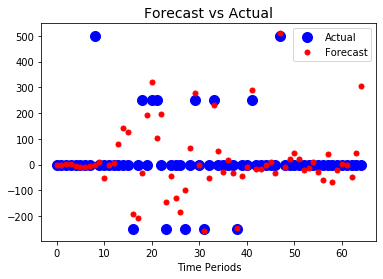

In [179]:
#Plotting test y data and our y-predicted forecast
plt.title("Forecast vs Actual", fontsize=14)
plt.plot(pd.Series(np.ravel(Y_test)), "bo", markersize=10, label="Actual")
#plt.plot(pd.Series(np.ravel(Y_test)), "w*", markersize=10)
plt.plot(pd.Series(np.ravel(y_pred)), "r.", markersize=10, label="Forecast")
plt.legend(loc="upper right")
plt.xlabel("Time Periods")
plt.show()